<a href="https://colab.research.google.com/github/KW-plato/CompCoxi/blob/main/notebook/Promise_Decision_Experiment_Ali%2BSaurabh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Overview of the Notebook


**Understanding the Dataset:**

1. Understand the the data of a subject and the trials, 
2. Plan which fields are giong to be used for further work and how.

**Data Wrangling:** 
1. Collate the data for all subjects, 
2. Clean the data - remove obvious errors,
3. Transform relevant fields for analysis,
4. Create a data-dictionary for reference.

**Exploration:**

Exploratory analysis to understand the main behavioral patterns.


**Analysis:**

1. Calculate specific metrics to quantify mouse trajectories and outcomes,
2. Run statistical tests to asnwer key questions.

**Afterword: Comments on Mouse-tracking:**

1. Identification and discussion of possible methodology related issues



In [ ]:
#Set-up to access the datasets stored in GitHub repo
!git clone https://github.com/KW-plato/CompCoxi.git

fatal: destination path 'CompCoxi' already exists and is not an empty directory.


In [ ]:
from ast import literal_eval
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

# set parameters to control look and feel of charts
sns.set_palette('tab10')
plt.rcParams["image.cmap"] = "tab10"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Link to the folder with the experiment data
datasrc = "/content/CompCoxi/Data"

# Create a list of all the csv files in the experiment data folder
datafiles = glob.glob(path.join(datasrc, '*.csv'))


# **Understanding the Dataset**

1. Out of the 48 csv files one selected randomly for exploring
2. Checked out the columns
3. Checked the first few and last few rows
4. Decided on columns which are useful for further analysis
5. Wrote down a data dictionary for reference

In [ ]:
"""
Read datafile of 1 randomly chosen subject from the 48 subject-datasets 
"""
df = pd.read_csv(datafiles[np.random.randint(len(datafiles))])
df.info() #check out the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Condition                35 non-null     object
 1   PromiseStage             35 non-null     object
 2   Stage                    35 non-null     object
 3   accuracy                 35 non-null     object
 4   avg_rt                   33 non-null     object
 5   count_decision_sequence  32 non-null     object
 6   count_loop1              33 non-null     object
 7   count_trial_sequence     33 non-null     object
 8   font_size                33 non-null     object
 9   height                   33 non-null     object
 10  init_time                33 non-null     object
 11  payoff                   32 non-null     object
 12  response                 33 non-null     object
 13  rt                       33 non-null     object
 14  subject_nr               33 non-null     obj

In [ ]:
display(df.head()) #check out the first few rows

,Condition,PromiseStage,Stage,accuracy,avg_rt,count_decision_sequence,count_loop1,count_trial_sequence,font_size,height,init_time,payoff,response,rt,subject_nr,synth_backend,tTrajectory,time_experiment,width,xTrajectory,yTrajectory
0,Promise,Wie oft werden Sie die Hälfte zurückgeben?,Promise,1,undefined,NaN,0,0,60,1080,471,NaN,1,1463,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 960, 960, 960, 960, 960, 960, 960, ...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101..."
1,Cond,DecisionB,Stage,accuracy,avg_rt,count_decision_sequence,count_loop1,count_trial_sequence,font_size,height,init_time,payoff,response,rt,subject_nr,synth_backend,tTrajectory,time_experiment,width,xTrajectory,yTrajectory
2,Trust,Teilnehmer A hat Ihnen 2 Punkte übermittelt.,Payback,1,undefined,0,0,0,60,1080,111,5,1,606,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 961, 964, 967, 969, 982, 990, 999, ...","[1010, 1010, 1010, 1008, 1007, 1006, 997, 988,..."
3,NoTrust,Teilnehmer A hat Ihnen keine 2 Punkte übermitt...,Payback,1,undefined,1,0,0,60,1080,111,0,1,606,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 961, 964, 967, 969, 982, 990, 999, ...","[1010, 1010, 1010, 1008, 1007, 1006, 997, 988,..."
4,Trust,Teilnehmer A hat Ihnen 2 Punkte übermittelt.,Payback,1,undefined,2,0,0,60,1080,141,5,1,710,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 960, 960, 960, 960, 960, 960, 960, ...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101..."


In [ ]:
display(df.tail()) #check out the last few rows

,Condition,PromiseStage,Stage,accuracy,avg_rt,count_decision_sequence,count_loop1,count_trial_sequence,font_size,height,init_time,payoff,response,rt,subject_nr,synth_backend,tTrajectory,time_experiment,width,xTrajectory,yTrajectory
30,Trust,Teilnehmer A hat Ihnen 2 Punkte übermittelt.,Payback,1,undefined,21,0,7,60,1080,111,5,1,542,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 960, 960, 960, 960, 962, 968, 980, ...","[1010, 1010, 1010, 1010, 1010, 1010, 1008, 100..."
31,Trust,Teilnehmer A hat Ihnen 2 Punkte übermittelt.,Payback,1,undefined,22,0,7,60,1080,101,5,1,663,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 960, 960, 960, 961, 964, 984, 1002,...","[1010, 1010, 1010, 1010, 1010, 1010, 1004, 978..."
32,Trust,Teilnehmer A hat Ihnen 2 Punkte übermittelt.,Payback,1,undefined,23,0,7,60,1080,81,5,1,702,0,legacy,"[11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,...",1145,1920,"[960, 960, 962, 967, 973, 985, 1023, 1052, 109...","[1010, 1010, 1008, 1003, 996, 988, 949, 914, 8..."
33,CHF,TotCHF,final_payoff,sum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,12.5,32.5,"[10, 5, 5, 5]",25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





1.   Decided to keep the following columns which seem meaningful:
'Condition', 'PromiseStage', 'Stage','accuracy','init_time','response', 'rt','tTrajectory', 'time_experiment','xTrajectory', 'yTrajectory'. The "Trajectory" columns are arrays/lists decribing the mouse trajectories. 
2.   Looks like the last 2 rows contain info captured by original experimenters for maintenance purposes. These rows will be dropped.
3. The header row seems to be again repeated on the 2nd row. That row will be dropped as well.

For all 48 subject files only the columns and rows identified here are retained for further processing.

In [ ]:
"""
Check the kind of values in the columns retained
"""
df = df[df['Condition'].isin(['Promise','NoTrust','Trust'])].reset_index() #drop rows (points 2,3 in note above)

for x in df.columns.to_list(): # Dont check the Trajectory columns. They are arrays
  if x in ['Condition', 'Stage','accuracy','init_time','response', 'rt']:
    print(df[x].value_counts())
    print('\n')

Trust      21
Promise     8
NoTrust     3
Name: Condition, dtype: int64


Payback    24
Promise     8
Name: Stage, dtype: int64


1    24
0     8
Name: accuracy, dtype: int64


111    8
91     7
101    4
81     4
121    3
141    3
471    1
131    1
181    1
Name: init_time, dtype: int64


1    24
2     8
Name: response, dtype: int64


710     2
765     2
696     2
606     2
703     2
856     1
598     1
584     1
613     1
580     1
601     1
663     1
597     1
726     1
702     1
532     1
589     1
660     1
1463    1
652     1
654     1
542     1
646     1
693     1
558     1
557     1
677     1
Name: rt, dtype: int64




Data Dictionary:
1. Condition: Contains trial type: Promise for Promise and Trust or NoTrust for Payback
2. Stage: Promise or Payback
3. accuracy: 1 or 0. We used this to decipher Yes/No responses
4. init_time: time taken to initiate mouse movement
5. response: 2(Payback) or 1 (Promise)
6. rt: response time time from start of trial to response i.e. click on the choice
7.tTrajectory: time points captured during the trial
6.xTrajectory: x(horizontal) position at each time point
7.yTrajectory: y(vertical) position at each time point


# **Data Wrangling**
1. Based on understanding gathered from exploration process all 48 csv files. Retain relevant columns and rows.
2. Rescale/standardize x values of Trajectory to [-1,1] and y values to [0,1.5]
3. Time normalize trajectories: x and y values of trajectory remapped to 101 evenly spaced time-bins
4. Flip all trajectory to right side. (steps 2 to 4 are done to allow comparison between the various trajectories).
5. Subtract 'init_time' from 'rt' to get 'tActive' i.e. the time the subject actively moved the mouse.
6. Assign every subject a numerical id and create a subject dataframe
7. Collate all subject data into a master dataframe

In [ ]:
"""
Utility functions for data wrangling
"""
 
def standardize_x(x_list):
    """
    In: An array with x (horizontal) co-ordinates of mouse trajectory of a trial
    Returns: standardized x-cordinates in the range [0,1] or [0,-1]
    """ 
    start = x_list[0]
    end = x_list[-1]
    if end > start:
        return (x_list - start) / (end - start)
    else:
        return -1 * (x_list - start) / (end - start)

def standardize_y(y_list):
    """
    In: An array with y (vertical) co-ordinates of mouse trajectory of a trial
    Returns: standardized y-cordinates in the range [0,1.5] 
    """ 
    start = y_list[0]
    end = y_list[-1]
    return 1.5 * (y_list - start) / (end - start)

def time_normalize(row): #can access by column names too since the whole row has been passed.Using number indexing to generalize
    """
    In: DF with 
     a. x or y co-ordinates of mouse trajectory of a trial
     b. the raw time points of each co-ordinate recording
     c. the time points normalized to 101 equidistant segments 
    Returns:  The  x or y co-ordinate normalized to 101 time-points
    """ 
    f = interp1d(row[0], row[1])
    return f(row[2])

def flip_to_right_side(x_list): # y remains same. x gets flipped i.e negative x become positive, if end is on left i.e. (-1,1.5)
    """
    In: An array with standardized x co-ordinates of mouse trajectory of a trial
    Returns: x-cordinates flipped to the right side 
    """
    if x_list[-1] < 0:
        return -1 * x_list
    else:
        return x_list


In [ ]:
"""
Process all the csv files
"""
# placeholder for participant info
participant_id = []
n_subjects = 0

for f in datafiles:
    df = pd.read_csv(f)
    f = path.basename(f)
    n_subjects += 1
    #assign a participant code for each file, since raw data doesnt have this info. Save this for future reference
    participant_id.append({
        'file': f,
        'participant_id': n_subjects
    })

    df = df[df['Condition'].isin(['Promise','NoTrust','Trust'])].reset_index()
    df = df[['Condition', 'Stage','accuracy','init_time','response', 'rt',
             'tTrajectory', 'time_experiment','xTrajectory', 'yTrajectory']]

    #set time variable to right format
    df['rt'] = df['rt'].apply(lambda x: float(x))
    df['init_time'] = df['init_time'].apply(lambda x: float(x))
    #tActive : time the subject moved the mouse i.e time from movement initiation till the end of response
    df['tActive'] = df['rt'] - df['init_time']

    df['tTrajectory'] = df['tTrajectory'].apply(lambda x: np.array(literal_eval(x)))
    df['xTrajectory'] = df['xTrajectory'].apply(lambda x: np.array(literal_eval(x)))
    df['yTrajectory'] = df['yTrajectory'].apply(lambda x: np.array(literal_eval(x)))

    #Remove trials with data recording error. max timestamp has to be less or equal to response time and more than zero
    df['tmax'] = df['tTrajectory'].apply(lambda x: x.max())
    df['tmin'] = df['tTrajectory'].apply(lambda x: x.min())
    df = df[df['tmax'] <= df['rt']]
    df = df[df['tmax'] > 0 ]
    
    # rescale start and end of every trial so that all trajectory across trials can be compared
    # Set Start (0,0). End (-1,1.5) if x decreases i.e left movement else (1,1.5)
    df['x_norm'] = df['xTrajectory'].apply(lambda x: standardize_x(x))
    df['y_norm'] = df['yTrajectory'].apply(lambda y: standardize_y(y))

    #time normalize trajectory by mapping each trial trajectory into 101 evenly spaced time-bins
    df['t_norm'] = df['tTrajectory'].apply(lambda x: np.linspace(x.min(), x.max(),101))
    df['x_norm'] = df[['tTrajectory', 'x_norm', 't_norm']].apply(lambda x: time_normalize(x), axis=1)
    df['y_norm'] = df[['tTrajectory', 'y_norm', 't_norm']].apply(lambda x: time_normalize(x), axis=1)

    # flip all trajectories to the right for comparability of all trajectories
    df['x_flip'] = df['x_norm'].apply(lambda x: flip_to_right_side(x))

    # Add the participant code and to the dataframe
    df['participant_id'] = n_subjects
    
    # Combine each subject data into a master dataframe with revevant data-fields only
    if n_subjects == 1:
        combined_data = df[['participant_id','Condition','Stage','accuracy','init_time','tActive',
                    'rt','t_norm','x_norm', 'y_norm','x_flip','xTrajectory','yTrajectory']]
    else:
        combined_data = pd.concat([
            combined_data,
            df[['participant_id','Condition','Stage','accuracy','init_time','tActive',
                'rt','t_norm','x_norm', 'y_norm','x_flip','xTrajectory','yTrajectory']]
                ], ignore_index=True)


In [ ]:
# create a dataframe on subject level information
subject_list = pd.DataFrame(participant_id,columns=['file','participant_id'])
# check the output of this stage
print("Combined master data shape: ",combined_data.shape)
print("Total no. of subjects: ",n_subjects)

Combined master data shape:  (1534, 13)
Total no. of subjects:  48


# **Exploration**

1. What do the response times (rt, init time and tActive) look like?
2. What do the mouse-trajectories look like?

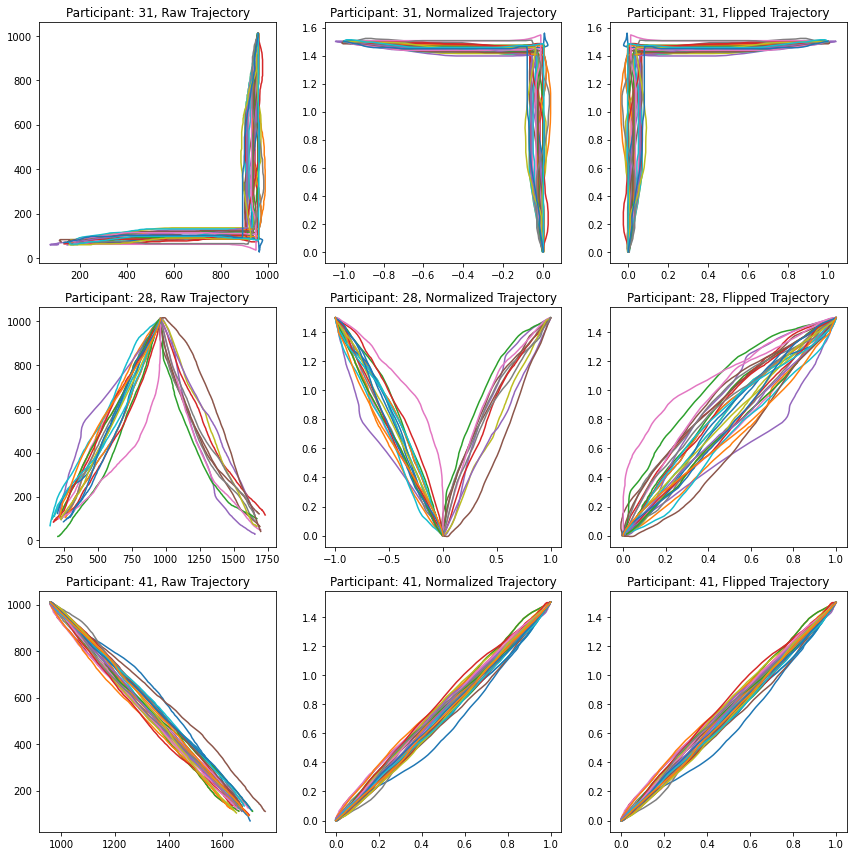

In [ ]:
"""
Randomly select 3 subjects, plot their original mouse trajectories from raw data.
Also plot the time normalized trajectories and the right flipped trajectory.

Trajectory = mouse movement on x-y plane
"""

def draw_trajectories(data,axes):
  for i in range(data.shape[0]):
    axes.plot(data.iloc[i][0],data.iloc[i][1])


n = 3
pids = subject_list['participant_id'].sample(n)

fig, ax = plt.subplots(n, 3,figsize=(12,12))
for idx,subj in enumerate(pids):
  data = combined_data[combined_data['participant_id'] == subj]
  ax[idx,0].set_title("Participant: {}, Raw Trajectory".format(subj))
  draw_trajectories(data[['xTrajectory','yTrajectory']],ax[idx,0])
  ax[idx,1].set_title("Participant: {}, Normalized Trajectory".format(subj))
  draw_trajectories(data[['x_norm','y_norm']],ax[idx,1])
  ax[idx,2].set_title("Participant: {}, Flipped Trajectory".format(subj))
  draw_trajectories(data[['x_flip', 'y_norm']],ax[idx,2])

plt.tight_layout()
plt.show()


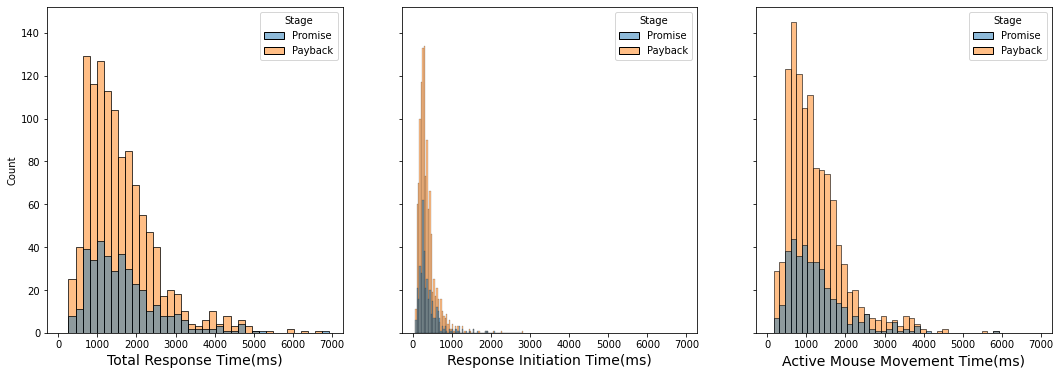

In [ ]:
"""
Plot histograms of response parameters.
1. Check difference between Promise and Payback trials
"""

fig, ax = plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
ax.ravel()
sns.histplot(data=combined_data,x='rt',hue='Stage',ax=ax[0])
ax[0].set_xlabel('Total Response Time(ms)',fontsize=14)
sns.histplot(data=combined_data,x='init_time',hue='Stage',ax=ax[1])
ax[1].set_xlabel('Response Initiation Time(ms)',fontsize=14)
sns.histplot(data=combined_data,x='tActive',hue='Stage',ax=ax[2])
ax[2].set_xlabel('Active Mouse Movement Time(ms)',fontsize=14)
plt.show()

The time taken to indicate the promise is lower than the response. Seems reasonable since during Payback trustees/subjects had the additional burden of considering the promise under which that trial is taking place. We have to be cautious though because Payback data points are 3 times more than Promise datapoints (only 8 per subject).

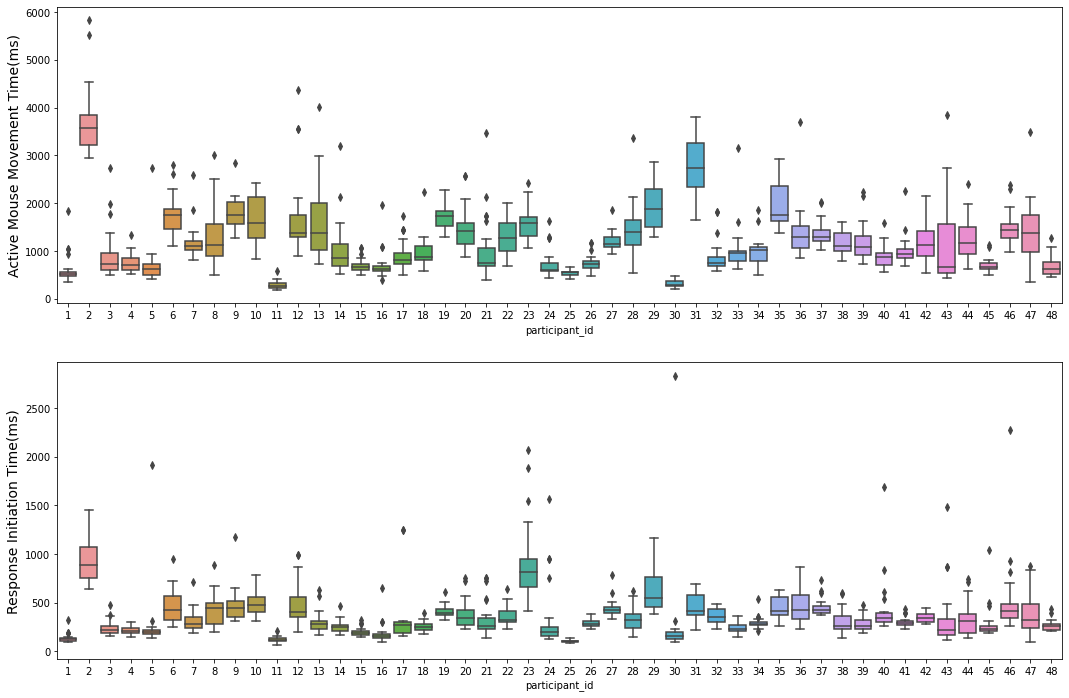

In [ ]:
"""
Check subject level distribution of init_time and tActive i.e.activity time.
We are not doing 'rt' plot here since these 2 times are a decomposition of 'rt' anyway
"""
fig,ax = plt.subplots(2,1,figsize=(18,12))
ax.ravel()
sns.boxplot(data=combined_data[combined_data['Stage']=='Payback'],y='tActive',x='participant_id',ax=ax[0])
ax[0].set_ylabel('Active Mouse Movement Time(ms)',fontsize=14)
sns.boxplot(data=combined_data[combined_data['Stage']=='Payback'],y='init_time',x='participant_id',ax=ax[1])
ax[1].set_ylabel('Response Initiation Time(ms)',fontsize=14)
plt.show()

Eye balling the plots it seems like people who have low(high) initiation time also have low(high) active time and vice versa. There is inter-subject variation but individual patterns are more or less same for the 2 parameters.

# **Analysis**



In [ ]:
#ensure accuracy is numeric since it will be used in calculation
combined_data['accuracy'] = pd.to_numeric(combined_data['accuracy'])

**Promise: pay back the investor or not?**

At each **PROMISE** trial subject makes a promise, which is either :


*   'Always' i.e. will payback to the investor always
*   'Sometimes' i.e. will payback the investor only sometimes 

The promise made holds for the immediately following **PAYBACK** trials, till next PROMISE trial comes or the experiment ends

Tagged each trial (each dataframe row) with its corresponding promise (always or sometimes). For promise rows it is same as the promise made in that row. For payback rows its the promise made in the last promise row.

*Note: The source dataset doesnt mention how the researchers originally tracked the Promise value. So we inferred a consistent rule based on our exploratory analysis of the dataset*. 


In [ ]:
"""
What was the promise made by the subject:
Available in the rows with the 'Promise' condition. 2 valid types 'sometimes' and 'always'.
Always: When accuracy value of the Promise trial is 1
Sometimes: When accuracy value of the Promise trial is 0
Set 'promise' of all other rows i.e the Payback rows to 'na' at this step
"""
conditions = [
    (combined_data['Condition'] == 'Promise') & (combined_data['accuracy'] == 0),
    (combined_data['Condition'] == 'Promise') & (combined_data['accuracy'] == 1),
    combined_data['Condition'] != 'Promise'
]
values = ['sometimes', 'always', 'na']
combined_data['promise'] = np.select(conditions, values)

In [ ]:
"""
Tag 'promise' value of each Payback row with the promise made in the last Promise trial.
"""
pr = combined_data[combined_data['Condition'] == 'Promise']['promise'].reset_index(level=0)
#the no. of payback trials dollowing each Promise row
pr['num_paybacks'] = pr['index'].shift(-1) - pr['index']   
pr['num_paybacks'].fillna(combined_data.shape[0] - pr.iloc[-1]['index'],inplace=True) 
pr['num_paybacks'] = pr['num_paybacks'].astype(int)
#copy 'promise' from Promise trial to the Payback trials following it
for i,index in enumerate(pr['index'].to_list()):
  for x in range(1,pr.loc[i,'num_paybacks']):
    combined_data.loc[index + x,'promise'] = pr.loc[i,'promise']

**Payback: Was investor paid back or not?**


For each Payback trial determined if the trustee/subject had paid the investor or not and added that info in the dataframe.

Furthermore, subjects/trustees had the option to payback only when they were 'trusted'. So payback is meaningful only when the trial condition was 'TRUST'.
So kept only the rows with Contition = Trust.

*Note: The researchers doesnt mention which data-field and what state conveys Yes or No wrt Payback. So we inferred a consistent rule based on our exploratory analysis of the dataset*. 


In [ ]:
"""
For each Payback row tag whether the trustee paidback money to the investor or not.
For Promise row the tag is 'na' since no money exchange happens.
"""
payback_condition = [(combined_data['Stage'] == 'Payback') & (combined_data['accuracy'] == 0),
                    (combined_data['Stage'] == 'Payback') & (combined_data['accuracy'] == 1),
                    (combined_data['Stage'] != 'Payback')
                    ]
condition_values = ['no', 'yes', 'na']
combined_data['payback'] = np.select(payback_condition, condition_values)

In [ ]:
"""
Keep only the rows with Contition = Trust
"""
combined_data = combined_data[(combined_data['Condition'] == 'Trust')]

**Identify subjects with different kind of Promise behaviours:**


*   Subjects who always promised 'always'
*   Subjects who always promised 'sometimes'
*   Subjects who promised both 'sometimes' and 'always' at various trials. Called this kind of subjects 'mixed'



In [ ]:
"""
Identify 3 kinds of subject behaviour
"""
subject_data = combined_data.groupby(['participant_id'])['promise'].value_counts(normalize=True).reset_index(name='val')
always = subject_data[(subject_data['promise'] == 'always') & (subject_data['val'] == 1)]['participant_id'].unique()
sometimes = subject_data[(subject_data['promise'] == 'sometimes') & (subject_data['val'] == 1)]['participant_id'].unique()
mixed = subject_data[~subject_data['participant_id'].isin(np.concatenate((always,sometimes)))]['participant_id'].unique()

In [ ]:
print("Total No. of subjects/Trustees in the experiment : {:2d}".format(n_subjects))
print("\n")
print("No. of participants who only promised 'always'   : {:2d} ({:6.2%})".format(len(always), len(always)/n_subjects))
print("No. of subjects who only promised 'sometimes'    : {:2d} ({:6.2%})".format(len(sometimes), len(sometimes)/n_subjects))
print("No. of subjects with mixed proimse")
print("                 i.e. both 'always' & sometimes' : {:2d} ({:6.2%})".format(len(mixed), len(mixed)/n_subjects))

Total No. of subjects/Trustees in the experiment : 48


No. of participants who only promised 'always'   : 27 (56.25%)
No. of subjects who only promised 'sometimes'    :  0 ( 0.00%)
No. of subjects with mixed proimse
                 i.e. both 'always' & sometimes' : 21 (43.75%)


Summary of Promise and Payback behavior

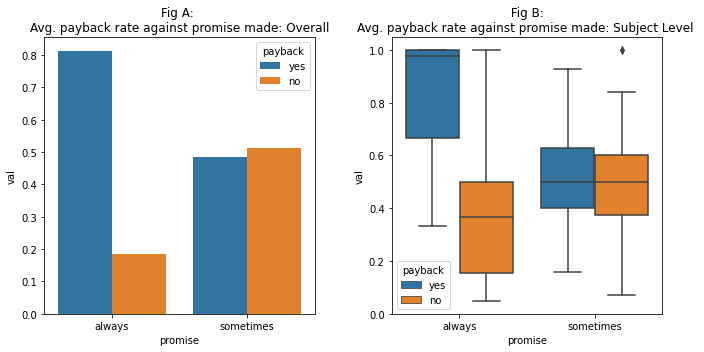

In [ ]:
d = combined_data.groupby(['promise'])['payback'].value_counts(normalize=True).reset_index(name='val')
dd= combined_data.groupby(['participant_id','promise'])['payback'].value_counts(normalize=True).reset_index(name='val')
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(data=d,x='promise',y='val',hue='payback',ax=ax[0])
ax[0].set_title("Fig A: \nAvg. payback rate against promise made: Overall")
sns.boxplot(data=dd,x='promise',y='val',hue='payback',ax=ax[1])
ax[1].set_title(" Fig B: \nAvg. payback rate against promise made: Subject Level ")
plt.tight_layout()
plt.show()

Fig A: Overall its clear that when trustees promise to 'always' return money to 
investors they comply. When they promise 'sometimes' their propensity to return money to investors is about chance.

Fig B: This exposes a large variation within the subjects noticeably when they promise 'always'. Well, overall that they are more likely to return money is still true. However, whereas some people always return money when they promise 'always', some never return money despite promising 'always'.
In the 'sometimes' promise trials the propensity to return money is rather balanced.

As a confirmation, we shall now do statistical tests for the following hypothesis:


---



**$H_0$:**There is no difference in the proportion of times trustees pay back investors after making an 'always' promise versus a 'sometimes' promise.

**$H_1$:** There is a difference in the proportion of times trustees pay back investors after making an 'always' promise versus a 'sometimes' promise.




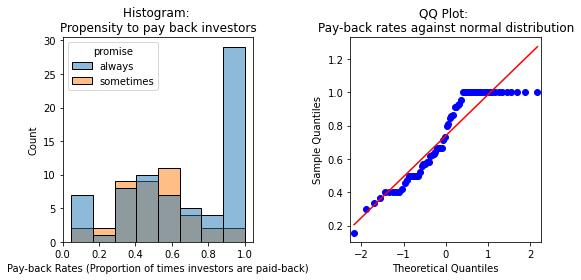

In [ ]:
"""
Check for normality before applying tests
"""
ddd = dd[dd['payback']=='yes']
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.histplot(data=dd,x='val',hue='promise',ax=ax[0])
ax[0].set_xlabel("Pay-back Rates (Proportion of times investors are paid-back)")
ax[0].set_title("Histogram: \nPropensity to pay back investors")
qqplot(data=ddd['val'],line='s',ax=ax[1])
ax[1].set_title("QQ Plot: \nPay-back rates against normal distribution")
plt.tight_layout()
plt.show()

Clearly, normality of the data cant be assumed here. 

In total, the situation we have is as follows:
1. The data for the two conditions is unbalanced;
2. As the box-plot in Fig B showed, the variance in the always and sometimes group cant be assumed to be same; and, 
3.  Payback rates cant be assumed to be normally distributed.

Under these circumstances, one of the accessible solutions is doing a Mann-Whitney U test, which is applied next.

In [ ]:
result = stats.mannwhitneyu(x=ddd[ddd['promise']=='always']['val'], y=ddd[ddd['promise']=='sometimes']['val'],alternative='greater')
verdict = '< 0.05 => H0 rejected' if result[1] < 0.05 else '> 0.05 => H0 not-rejected'
print("Test Statistic: {} p-value: {:0.7f} {}".format(result[0],result[1],verdict))

Test Statistic: 788.5 p-value: 0.0000014 < 0.05 => H0 rejected


So we conclude that the trustees are more likely to pay back investors after making an 'always' promise than after a 'sometimes' promise.

**'Keep' or 'Break' a promise**

At each Payback trial, based on whether the trustee/subject paid the investor or not the concept of keeping or breaking the promise can be established. 


*   Keep: The subject "keep"s her promise if the Promise (indicated by subject in the Promise trial corresponding to the Payback trial) is 'always' and the subject actually paid back the investor.
*   Break: The subject "break"s her promise if the Promise (indicated by subject in the Promise trial corresponding to the Payback trial) is 'always' and the subject didn't pay back the investor.


If the promise made was 'sometimes', then keeping or breaking doesnt make perfect sense since the subject hadnt taken a clear stand whether she will pay or not pay the investor on a trial. 



In [ ]:
"""
For each Payback trial tag the outcome as keep or break. Valid only for Payback trials. 
Outcome = "break" if promise is broken, and 
Outcome = "keep" if promise is kept.
For Promise trials and for trials after 'sometimes' promise the outcome will be set to 'na'.
"""
payoff_condition = [(combined_data['Stage'] == 'Payback') & (combined_data['promise'] == 'always') & (combined_data['payback'] == 'yes'),
               (combined_data['Stage'] == 'Payback') & (combined_data['promise'] == 'always') & (combined_data['payback'] == 'no'),
               (combined_data['Stage'] == 'Payback') & (combined_data['promise'] == 'sometimes'),
               combined_data['Stage'] != 'Payback']
condition_values = ['keep', 'break', 'na', 'na']
combined_data['outcome'] = np.select(payoff_condition, condition_values)

Promise trials are removed for the next stage of analysis since only Payback trials will be analyzed.

In [ ]:
# keep only the data of payback trials 
filtered = combined_data[(combined_data['Stage'] == 'Payback')]

**Promise keepers and Promise breakers**


*   Keeper: On Payback trials with Promise=always, Outcome is always keep
*   Breaker: On Payback trials with Promise=always, Òutcome is sometimes break



In [ ]:
"""
Promise Keepers   : Always keep the promise 
Promise Breakers : Sometimes break their promise
"""
#analyse only trials with Outcome != 'na', since 'na' outcomes are when promise is 'sometimes' where keep/break isnt well defined
behavior = filtered[filtered['outcome'] != 'na'].groupby(['participant_id'])['outcome'].value_counts(normalize=True).reset_index(name='val')
keepers = behavior[(behavior['outcome'] == 'keep') &
                   (behavior['val'] == 1)]['participant_id'].unique()
breakers = behavior[(behavior['outcome'] == 'break') &
                   (behavior['val'] > 0)]['participant_id'].unique()

filtered['group'] = 'keeper'
filtered.loc[filtered['participant_id'].isin(breakers),'group'] = 'breaker'

print("Promise Keepers  : {:2d} ({:.2%})".format(len(keepers), len(keepers)/(len(keepers)+len(breakers))))
print("Promise Breakers : {:2d} ({:.2%})".format(len(breakers), len(breakers)/(len(keepers)+len(breakers))))

Promise Keepers  : 23 (47.92%)
Promise Breakers : 25 (52.08%)


In [ ]:
# keepers and breakers in the 'always' promise group i.e. those who never promised 'sometimes'
always_keepers = [x for x in always if x in keepers]
always_breakers = [x for x in always if x in breakers]
# keepers and breakers in the mixed promise group i.e. those who had both 'always' and 'sometimes' promises
mixed_keepers = [x for x in mixed if x in keepers]
mixed_breakers = [x for x in mixed if x in breakers]
# we had already seen that only 'sometimes' promise group has no subjects. So only these 2 groups are relevant

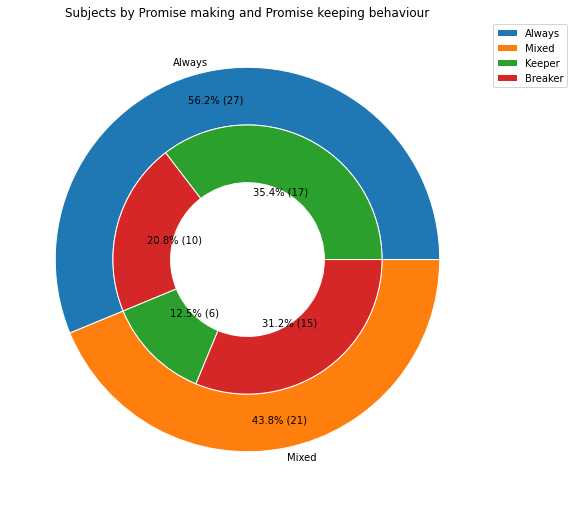

In [ ]:
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ({:d})".format(pct, absolute)

def draw_pie(vals,axes,out_labels,in_labels):
  size = 0.3
  radius_out = 1.0
  radius_in = radius_out - size
  cmap = plt.get_cmap()
  outer_colors = cmap(np.arange(2))
  inner_colors = cmap([2, 3, 2, 3])
  axes.pie(vals.sum(axis=1),radius=radius_out, colors=outer_colors, autopct=lambda pct: func(pct, vals.sum(axis=1)),pctdistance=radius_out*0.85,
       wedgeprops=dict(width=size, edgecolor='w'),labels=out_labels, labeldistance=radius_out*1.05)
  axes.pie(vals.flatten(),radius=radius_in, colors=inner_colors, autopct=lambda pct: func(pct, vals.flatten()),pctdistance=radius_in*0.8,
       wedgeprops=dict(width=size, edgecolor='w'))
  axes.legend(out_labels + in_labels, bbox_to_anchor=(1, 1), loc='upper left')


fig, ax = plt.subplots(1,1,figsize=(8,8))
vals = np.array([[len(always_keepers),len(always_breakers)], [len(mixed_keepers),len(mixed_breakers)]])
out_labels = ['Always','Mixed']
in_labels = ['Keeper','Breaker'] 
draw_pie(vals,ax,out_labels,in_labels) 
ax.set_title("Subjects by Promise making and Promise keeping behaviour",pad=3)  
plt.tight_layout()
plt.show()


We now focus on promise keeping and breaking behaviour. 
Plot histograms of reaction time, mouse movement intiation time and active time i.e. the time taken from movement initiation till response completion for 'keep' and 'break' outcomes

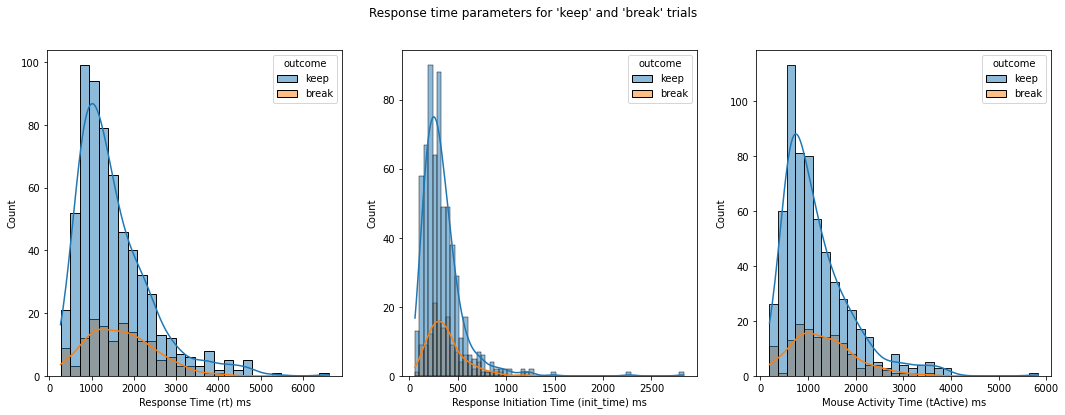

In [ ]:
filtered = filtered[filtered['outcome'] != 'na']
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax.ravel()
sns.histplot(data=filtered,x='rt',ax=ax[0],hue='outcome',kde=True)
ax[0].set_xlabel("Response Time (rt) ms")
sns.histplot(data=filtered,x='init_time',ax=ax[1],hue='outcome',kde=True)
ax[1].set_xlabel("Response Initiation Time (init_time) ms")
sns.histplot(data=filtered,x='tActive',ax=ax[2],hue='outcome',kde=True)
ax[2].set_xlabel("Mouse Activity Time (tActive) ms")
plt.suptitle("Response time parameters for 'keep' and 'break' trials")
plt.show()

Looks like the response time parameters are different for promise keep and break outcomes. Again as response time = init_time + tActive. We do statistical tests of significance for only Initiation time and Activity time. 



---


Initiation Time:

$H_0$: There is no difference in initiation time between the keep and break trials

$H_1$: There is a difference in initiation time between the keep and break trials

Activity Time:

$H_0$: There is no difference in activity time between the keep and break trials

$H_1$: There is a difference in activity time between the keep and break trials.



Here too we have the same challlenges as in the previous test. The data in the 'keep' and 'break' groups is unbalanced and may not be normal(we formally check for normality in the next cell). Mann-Whitney U test is used again for significance testing.

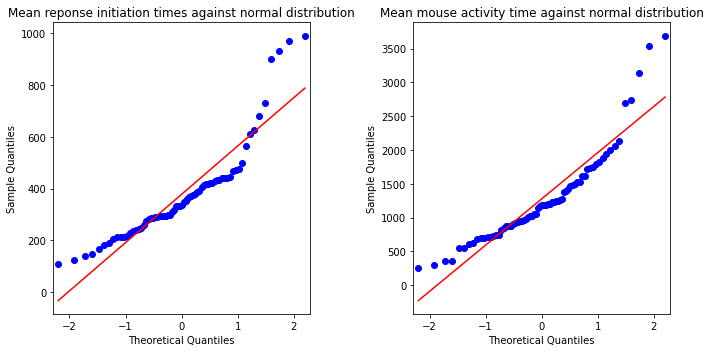

In [ ]:
result = {}
fig, ax = plt.subplots(1,2,figsize=(10,5))
ddd = filtered.groupby(['participant_id','outcome'])['init_time'].mean().reset_index(name='mean_init_t')
result['init_time'] = stats.mannwhitneyu(x=ddd[ddd['outcome']=='keep']['mean_init_t'], y=ddd[ddd['outcome']=='break']['mean_init_t'])
qqplot(data=ddd['mean_init_t'],line='s',ax=ax[0])
ax[0].set_title("Mean reponse initiation times against normal distribution",fontsize=12)
ddd = filtered.groupby(['participant_id','outcome'])['tActive'].mean().reset_index(name='mean_tActive')
result['tActive'] = stats.mannwhitneyu(x=ddd[ddd['outcome']=='keep']['mean_tActive'], y=ddd[ddd['outcome']=='break']['mean_tActive'])
qqplot(data=ddd['mean_tActive'],line='s',ax=ax[1])
ax[1].set_title("Mean mouse activity time against normal distribution",fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
for x in ['init_time','tActive']:
  print(x,":")
  verdict = '< 0.05 => H0 rejected' if result[x][1] < 0.05 else '> 0.05 => H0 not-rejected'
  print("Test Statistic: {} p-value: {:0.3f} {}\n".format(result[x][0],result[x][1],verdict))


init_time :
Test Statistic: 492.5 p-value: 0.162 > 0.05 => H0 not-rejected

tActive :
Test Statistic: 481.0 p-value: 0.130 > 0.05 => H0 not-rejected



So based on response time parameters it cant be asserted that Keep and Break trials have different dynamics. 

This leaves the door open for analysing the mouse trajectories. Do the mouse trajectories capture differential cognitive conflict between keep and break responses?

**Metrics for Mouse Trajectory**

The deviation of the mouse from the theoretical trajectory i.e. a straight line connecting the start and end points of the motion is studied as an indicator of the evolving decision dynamics.

Two such metrics are used:


*   MD (maximum deviation): Largest perpendicular deviation between the real  trajectory and the theoretical trajectory. Since we have 101 points on the trajectory, we haved appromixated MD using the point whose perpendicular distance from the theoterical trajectory is maximum.
*   AUC (area under the curve): Area between the theoretical trajectory and the actual trajectory. We have calculated this using trapezoidal rule of integration.

*Note: We have used straight-forward implementations so results may differ with others. But the methods we use are directly derived from the underlying math and so deviations are purely due to approximations used.*


In [ ]:
"""
Calculate MD(max_dev) using projection matrix
"""
def calculate_MaxDev(data):
  x = np.array([1,1.5]).reshape(2,1) #vector representation of theoretical trajectory
  projection_m = np.dot(x,x.T) / np.dot(x.T,x) #projection matrix
  points = np.stack((data[0],data[1]))
  perp = points - np.matmul(projection_m,points) #vector representation of the perpendicular
  return (np.linalg.norm(perp,axis=0).max())

filtered['max_dev'] = filtered[['x_flip','y_norm']].apply(lambda x:calculate_MaxDev(x),axis=1)

In [ ]:
"""
Calculate AUC using numerical integration
"""
def calculate_AUC(data):
  
  return (trapz(data[1],data[0]) - 0.5*1.5)

filtered['AUC'] = filtered[['x_flip','y_norm']].apply(lambda x:calculate_AUC(x),axis=1)

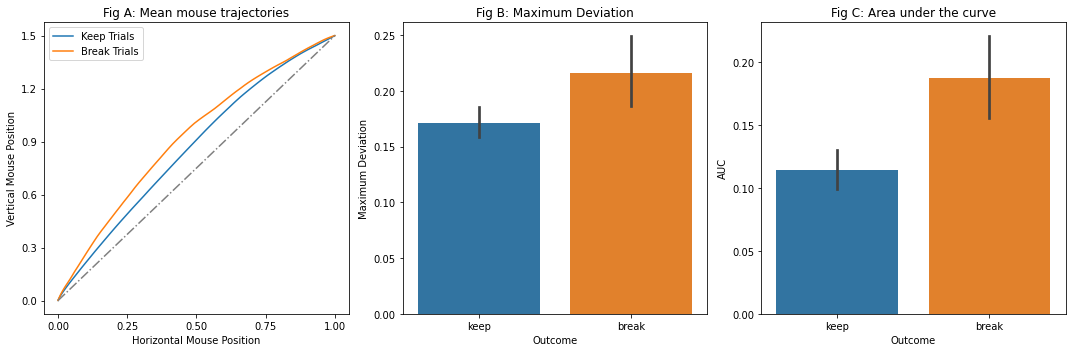

In [ ]:
"""
compare the mouse trajectory of keep and break behaviours
"""
tmpdf = filtered[filtered['outcome'] == 'keep']
xsk = tmpdf['x_flip'].sum() / tmpdf.shape[0]
ysk = tmpdf['y_norm'].sum() / tmpdf.shape[0]

tmpdf = filtered[filtered['outcome'] == 'break']
xsb = tmpdf['x_flip'].sum() / tmpdf.shape[0]
ysb = tmpdf['y_norm'].sum() / tmpdf.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax.ravel()
ax[0].set_title("Fig A: Mean mouse trajectories")
ax[0].set_ylabel('Vertical Mouse Position')
ax[0].set_yticks(np.linspace(0,1.5,6))
ax[0].set_xlabel('Horizontal Mouse Position')
ax[0].set_xticks(np.linspace(0,1.0,5))
ax[0].plot(xsk,ysk,label='Keep Trials')
ax[0].plot(xsb,ysb,label='Break Trials')
ax[0].plot([0,1],[0,1.5], color='gray', linestyle='-.')
ax[0].legend(loc='upper left')

b01 = sns.barplot(x='outcome',y='max_dev',data=filtered,ax=ax[1])
b01.set(xlabel='Outcome', ylabel='Maximum Deviation',title='Fig B: Maximum Deviation')
b02 = sns.barplot(x='outcome',y='AUC',data=filtered,ax=ax[2])
b02.set(xlabel='Outcome', ylabel='AUC',title='Fig C: Area under the curve')
plt.tight_layout()
plt.show()

Fig A: Both trajectories show curvature towards the reponse opposite to the one finally chosen. This demonstrates conflict during decicion making. Moreover, the trajectories in break trial are much more attracted towards the opposite reponse showing more conflict in decision making before subjects broke a promise.


Fig B and Fig C show that both the quantitative measures of curvature show larger mean value and more variation in break trials as compared to keep trials. Thus the trajectory, MD and AUC are pointing in the same direction- break trials contain more conflict. 
We directly apply the statistical tests on MD and AUC to validate the observations from the chart.



Maximum Deviation (MD):

$H_0$: 
There is no difference in MD of mouse trajectories between the keep and break trials.

$H_1$: 
There is a difference in the MD of mouse trajectories between the keep and break trials


In [ ]:
ddd = filtered.groupby(['participant_id','outcome'])['max_dev'].mean().reset_index(name='mean_MD')
result = stats.mannwhitneyu(x=ddd[ddd['outcome']=='keep']['mean_MD'], y=ddd[ddd['outcome']=='break']['mean_MD'])
verdict = '< 0.05 => H0 rejected' if result[1] < 0.05 else '> 0.05 => H0 not-rejected'
print("Test Statistic: {} p-value: {:0.4f} {}".format(result[0],result[1],verdict))

Test Statistic: 376.0 p-value: 0.0084 < 0.05 => H0 rejected


Area under the Curve (AUC):

H0: There is no difference in AUC of mouse trajectories between the keep and break trials.

H1: There is a difference in the AUC of mouse trajectories between the keep and break trials


In [ ]:
ddd = filtered.groupby(['participant_id','outcome'])['AUC'].mean().reset_index(name='mean_AUC')
result = stats.mannwhitneyu(x=ddd[ddd['outcome']=='keep']['mean_AUC'], y=ddd[ddd['outcome']=='break']['mean_AUC'])
verdict = '< 0.05 => H0 rejected' if result[1] < 0.05 else '> 0.05 => H0 not-rejected'
print("Test Statistic: {} p-value: {:0.4f} {}".format(result[0],result[1],verdict))

Test Statistic: 429.0 p-value: 0.0399 < 0.05 => H0 rejected


Tests on both MD and AUC concur. We can safely conclude that the mouse trajectories of keep and break trials are indeed different. We see heightened conflict in decision making reflected in mouse trajectories. This conflict is higher when subjects are about to break a promise compared to when they are about to keep a promise. 

Thus, mouse trajectory contained information on decision dynamics which wasnt captured in response time parameters. 

The final curiosity we have is specifically about promise keepers and breakers.




1.   Keepers and Breakers: They both have keep trials. Are the keep trials of these groups similar?

2.   Keep and Break trial of breakers: Breakers had both kind of responses i.e. where they kept their promise and where they broke their promise. Can we expect that the mouse-tracjetories in their keep trials and in their break trials capture the dynamics?  



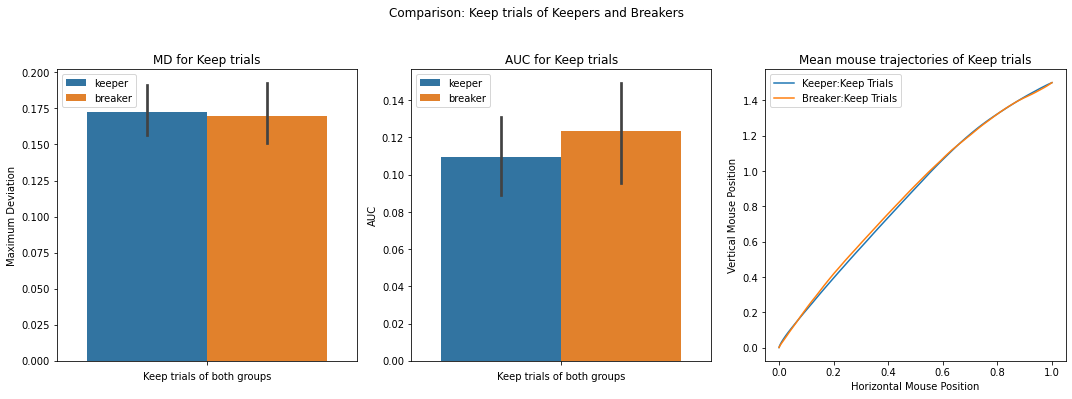

In [ ]:
"""
Evaluate Keep trials of Keepers and Breakers
"""
fig, ax = plt.subplots(1,3,figsize=(15,5))

palette ={"keeper": "C0", "breaker": "C1"}
hue_order = ["keeper","breaker"]

b00 = sns.barplot(x='outcome',y='max_dev',hue='group',data=filtered[filtered['outcome']=='keep'],palette=palette,hue_order=hue_order,ax=ax[0])
b00.set(xlabel='Keep trials of both groups', xticklabels=[], ylabel='Maximum Deviation',title='MD for Keep trials')
ax[0].legend(loc='upper left')
b01 = sns.barplot(x='outcome',y='AUC',hue='group',data=filtered[filtered['outcome']=='keep'],palette=palette,hue_order=hue_order,ax=ax[1])
b01.set(xlabel='Keep trials of both groups', xticklabels=[], ylabel='AUC',title='AUC for Keep trials')
ax[1].legend(loc='upper left')
tmpdf = filtered[(filtered['group']=='keeper') & (filtered['outcome']=='keep') ]
xs = tmpdf['x_flip'].sum() / tmpdf.shape[0]
ys = tmpdf['y_norm'].sum() / tmpdf.shape[0]
ax[2].plot(xs,ys,label='Keeper:Keep Trials')
tmpdf = filtered[(filtered['group']=='breaker') & (filtered['outcome']=='keep') ]
xs = tmpdf['x_flip'].sum() / tmpdf.shape[0]
ys = tmpdf['y_norm'].sum() / tmpdf.shape[0]
ax[2].plot(xs,ys,label='Breaker:Keep Trials')
ax[2].legend(loc='upper left')
ax[2].set_title('Mean mouse trajectories of Keep trials')
ax[2].set_xlabel('Horizontal Mouse Position')
ax[2].set_ylabel('Vertical Mouse Position')
plt.suptitle("Comparison: Keep trials of Keepers and Breakers",y=1.1)
plt.tight_layout()
plt.show()

The profile for keep trials for both groups of subject appear quite similar specifically the mean trajectories and MD. Since the AUC shows some apparent difference we decided to do the statistical test to satisfy ourselves.

In [ ]:
ddd = filtered[filtered['outcome']=='keep'].groupby(['participant_id','group'])['AUC'].mean().reset_index(name='mean_AUC')
print("Test statistics for AUC")
display(stats.mannwhitneyu(x=ddd[ddd['group']=='keeper']['mean_AUC'], y=ddd[ddd['group']=='breaker']['mean_AUC']))


Test statistics for AUC


MannwhitneyuResult(statistic=198.0, pvalue=0.07353401204071644)

So we can't reject the hypothesis that the keep trials of Keepers and Breakers are basically similar. This intuitively makes sense as well.

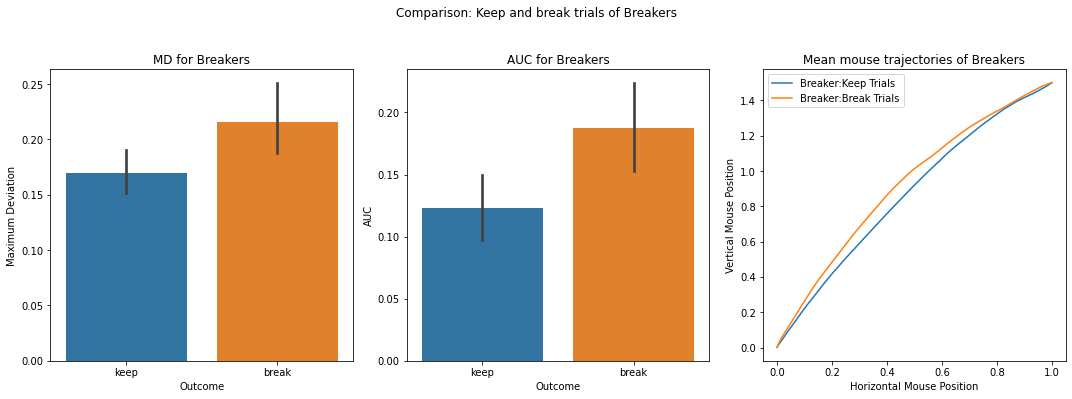

In [ ]:
"""
Evaluate Keep and Break trials of Breakers
"""
fig, ax = plt.subplots(1,3,figsize=(15,5))

palette ={"keeper": "C0", "breaker": "C1"}
hue_order = ["keeper","breaker"]

b10 = sns.barplot(x='outcome',y='max_dev',data=filtered[filtered['group']=='breaker'],ax=ax[0])
b10.set(xlabel='Outcome',ylabel='Maximum Deviation',title='MD for Breakers')

b11 = sns.barplot(x='outcome',y='AUC',data=filtered[filtered['group']=='breaker'],ax=ax[1])
b11.set(xlabel='Outcome',ylabel='AUC',title='AUC for Breakers')

tmpdf = filtered[(filtered['group']=='breaker') & (filtered['outcome']=='keep') ]
xs = tmpdf['x_flip'].sum() / tmpdf.shape[0]
ys = tmpdf['y_norm'].sum() / tmpdf.shape[0]
ax[2].plot(xs,ys,label='Breaker:Keep Trials')
tmpdf = filtered[(filtered['group']=='breaker') & (filtered['outcome']=='break') ]
xs = tmpdf['x_flip'].sum() / tmpdf.shape[0]
ys = tmpdf['y_norm'].sum() / tmpdf.shape[0]
ax[2].plot(xs,ys,label='Breaker:Break Trials')
ax[2].legend(loc='upper left')
ax[2].set_title('Mean mouse trajectories of Breakers')
ax[2].set_xlabel('Horizontal Mouse Position')
ax[2].set_ylabel('Vertical Mouse Position')
plt.suptitle("Comparison: Keep and break trials of Breakers",y=1.1)
plt.tight_layout()
plt.show()

MD, AUC as well as the average trajectories show that keep and break trials of the Breaker group have a difference which is analogous the overall difference between the keep and break trials that we have already established.

 **SUMMARY**

1. When subjects made a definite promise i.e. in the 'always' condition, then they kept their promise significantly more than when they made an ambiguous promise i.e. the 'sometimes' condition.
2.   Subjects show difference in cognitive processes between keeping and breaking a promise. The decision dynamics is more conflicted when breaking a promise versus when keeping a promise.
3.   Standard response time analysis wasnt able to distinguish between these two conditions but analysis of mouse trajectories of the responses exposed the differential dynamics underlying keeping versus breaking a promise.




## **Afterword: Comments on Mouse-Tracking Method**


The dataset we analyzed showed that mouse tracking indeed was able to capture evolution of a decision which otherwise wasnt reflected in the reponse time parameters. 

We did some further excursions on the theme of Mouse-tracking. Here we summarize two interesting methodological observations.

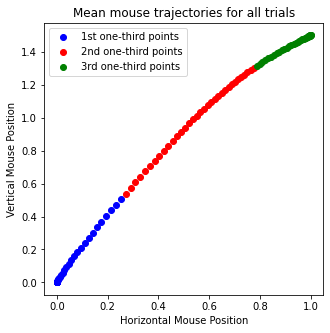

In [ ]:
avg_x = filtered['x_flip'].sum()/filtered.shape[0]
avg_y = filtered['y_norm'].sum()/filtered.shape[0]
s = len(avg_x)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(avg_x[:int(s/3)],avg_y[:int(s/3)],color='blue',label='1st one-third points')
ax.scatter(avg_x[int(s/3):int(2*s/3)],avg_y[int(s/3):int(2*s/3)],color='red',label='2nd one-third points')
ax.scatter(avg_x[int(2*s/3):],avg_y[int(2*s/3):],color='green',label='3rd one-third points')
ax.set_title('Mean mouse trajectories for all trials')
ax.set_xlabel('Horizontal Mouse Position')
ax.set_ylabel('Vertical Mouse Position')
ax.legend(loc='upper left')
plt.show()

The chart above shows the mean trajectory from all trials. The colored highlights show first(blue), middle (red) and last (green) one-thirds of the trajectory points. Very clearly the points are not evenly distributed in the x-y plane. They are closely bunched at the start and end of the trajectory and scattered in the middle.

We tried to understand this issue and found the following comment in a recent study- 

"Movements are typically slow at the beginning and end of the trajectory (due to movement initiation and target approach) and fast in-between, resulting in an uneven distribution of points over the path of the trajectory. Time-normalized trajectories therefore place excessive weight on the relatively uninformative end and start phases of trajectories". 

So time-normalization(into 101 equal bins) that is commonly used overemphasizes the slow movement parts and underemphasize the fast movement parts of the recorded mouse trajectory. Unfortunaletly, this middle-part that gets underemphasized is where most of the decision conflict may be located. 

To remedy this problem some recent papers have opted to use "spatial analogue of time-normalization, which represents trajectories using a fixed number of points equidistant in terms of their x- and y-positions on the screen, rather than in terms of time." 

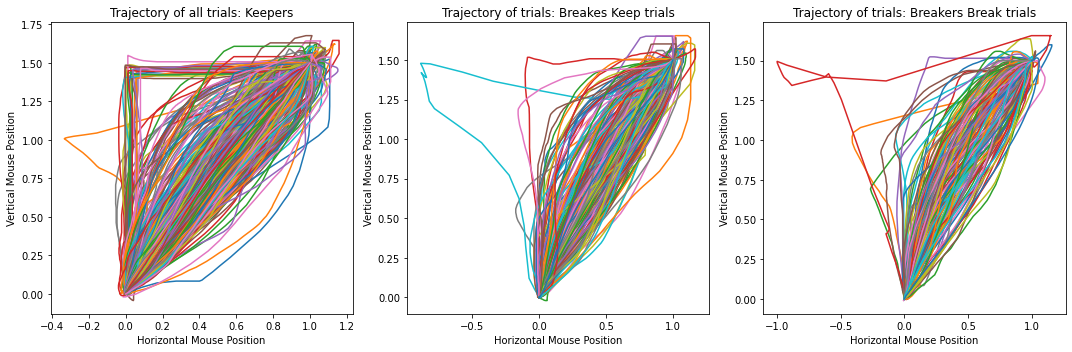

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
tmpdf = filtered[(filtered['group']=='keeper')]
draw_trajectories(tmpdf[['x_flip','y_norm']],ax[0])
ax[0].set_title('Trajectory of all trials: Keepers')
ax[0].set_xlabel('Horizontal Mouse Position')
ax[0].set_ylabel('Vertical Mouse Position')
tmpdf = filtered[(filtered['group']=='breaker') & (filtered['outcome']=='keep')]
draw_trajectories(tmpdf[['x_flip','y_norm']],ax[1])
ax[1].set_title("Trajectory of trials: Breakes Keep trials")
ax[1].set_xlabel('Horizontal Mouse Position')
ax[1].set_ylabel('Vertical Mouse Position')
tmpdf = filtered[(filtered['group']=='breaker') & (filtered['outcome']=='break')]
draw_trajectories(tmpdf[['x_flip','y_norm']],ax[2])
ax[2].set_title("Trajectory of trials: Breakers Break trials")
ax[2].set_xlabel('Horizontal Mouse Position')
ax[2].set_ylabel('Vertical Mouse Position')
plt.tight_layout()
plt.show()

The plots above show all the trajectrories of the key interest groups.
We immediately notice a huge variation in the type of the trajectories. For eg. trials of Keepers were expected to be somewhat similar since from the overall outcome perspective they were very uniform. But the individual trajectories have numerous variations. Some are almost colinear with the theoretical trajectory, some curved towards the opposite choice, some curved towards the final choice and some L shaped (as if the subject just moved upwards and at the final moment dashed to the final choice).

If we were to do another mouse-tracking exercise, it may be worthwhile to do fine-grained analysis of what kinds of trajectories are there and what meaning can be derived from those patterns. 